In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [66]:
df = pd.read_excel('data.xlsx')
df_normalized = df.copy()

for column in df.columns:
    min_val = df[column].min()
    max_val = df[column].max()
    df_normalized[column] = 2 * (df[column] - min_val) / (max_val - min_val) - 1

min_vals = df.min()
max_vals = df.max()
data_tensor = torch.tensor(df_normalized.values, dtype=torch.float32)
dataset = TensorDataset(data_tensor)

batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

input_dim = df.shape[1] 
latent_dim = 100

In [67]:
df

,cov1,cov2,cov3,cov4,cov5,cov6,cov7,sal_pur_rat,igst_itc_tot_itc_rat,lib_igst_itc_rat
0,0.997797,0.999888,0.215934,0.196713,0.000000,0.955616,0.998810,-0.032581,1.761759,-0.054329
1,0.994004,0.979902,-0.337135,-0.248634,0.000000,0.640812,0.553918,-0.032026,-0.629311,-0.053516
2,0.947603,0.455667,0.001743,0.128610,-0.004054,-0.162069,0.960601,-0.030209,1.535697,-0.054215
3,0.396577,0.919933,0.496451,0.576824,-0.340718,0.802363,0.673710,-0.032058,0.449160,-0.054126
4,0.999893,0.327615,0.700477,0.315601,0.000000,0.300785,0.979009,-0.032224,1.762049,-0.054330
...,...,...,...,...,...,...,...,...,...,...
1194,1.000000,0.670847,0.566994,0.325485,0.000000,0.263078,0.211872,-0.030984,-1.053454,-0.004980
1195,0.999503,0.994784,0.847388,0.807294,0.000000,0.992071,0.779629,-0.032152,-0.867659,-0.051979
1196,0.999999,0.751775,-0.209639,-0.052031,0.000000,0.818428,0.850427,-0.032923,-0.517706,-0.053754
1197,0.999992,0.997277,0.199312,0.190436,0.000000,0.534354,0.119579,-0.032986,-1.031108,-0.043029


In [68]:
df_normalized

,cov1,cov2,cov3,cov4,cov5,cov6,cov7,sal_pur_rat,igst_itc_tot_itc_rat,lib_igst_itc_rat
0,0.996642,0.999853,0.137502,0.139463,-0.162655,0.947249,0.998720,-0.999841,0.743441,-0.999993
1,0.990861,0.973761,-0.470892,-0.350421,-0.162655,0.573091,0.520220,-0.999809,-0.730534,-0.999944
2,0.920140,0.289362,-0.098115,0.064549,-0.167373,-0.381167,0.957625,-0.999703,0.604084,-0.999986
3,0.080302,0.895471,0.446080,0.557587,-0.559111,0.765101,0.649062,-0.999811,-0.065711,-0.999981
4,0.999837,0.122189,0.670515,0.270240,-0.162655,0.168954,0.977423,-0.999820,0.743619,-0.999993
...,...,...,...,...,...,...,...,...,...,...
1194,1.000000,0.570285,0.523679,0.281113,-0.162655,0.124138,0.152335,-0.999748,-0.991997,-0.997024
1195,0.999243,0.993191,0.832122,0.811106,-0.162655,0.990577,0.762982,-0.999816,-0.877464,-0.999851
1196,0.999999,0.675938,-0.330642,-0.134156,-0.162655,0.784195,0.839128,-0.999861,-0.661736,-0.999958
1197,0.999987,0.996445,0.119217,0.132558,-0.162655,0.446561,0.053070,-0.999865,-0.978222,-0.999313


In [69]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.05),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.05),
            nn.Linear(128, 1),
            nn.Sigmoid()       
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, latent_dim, input_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(latent_dim,128),
            nn.LeakyReLU(0.05),
            nn.Linear(128,128),
            nn.LeakyReLU(0.05),
            nn.Linear(128, input_dim),
            nn.Tanh()  
        )

    def forward(self, z):
        return self.gen(z)

In [70]:
generator = Generator(latent_dim, input_dim).to(device)
discriminator = Discriminator(input_dim).to(device)
criterion = nn.BCELoss()

lr = 0.00015
optim_g = optim.Adam(generator.parameters(), lr=lr)
optim_d = optim.Adam(discriminator.parameters(), lr=lr)
num_epochs = 1000
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for i, real_data in enumerate(dataloader):
        real_data = real_data[0].to(device)
        batch_size = real_data.size(0)

        true_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # -----------------------
        discriminator.zero_grad()
        real_output = discriminator(real_data)
        d_loss_true = criterion(real_output, true_labels)

        z = torch.randn(batch_size, latent_dim, device=device)
        fake_data = generator(z)
        fake_output = discriminator(fake_data.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_true + d_loss_fake
        d_loss.backward()
        optim_d.step()

        # -----------------------
        generator.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_data = generator(z)
        fake_output = discriminator(fake_data)
        g_loss = criterion(fake_output, true_labels)
        g_loss.backward()
        optim_g.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.3f}, g_loss: {g_loss.item():.3f}')

Epoch [50/1000], d_loss: 1.090, g_loss: 1.102
Epoch [100/1000], d_loss: 1.360, g_loss: 0.606
Epoch [150/1000], d_loss: 1.433, g_loss: 0.701
Epoch [200/1000], d_loss: 1.383, g_loss: 0.748
Epoch [250/1000], d_loss: 1.173, g_loss: 0.777
Epoch [300/1000], d_loss: 1.457, g_loss: 0.772
Epoch [350/1000], d_loss: 1.364, g_loss: 0.722
Epoch [400/1000], d_loss: 1.459, g_loss: 0.701
Epoch [450/1000], d_loss: 1.385, g_loss: 0.673
Epoch [500/1000], d_loss: 1.426, g_loss: 0.745
Epoch [550/1000], d_loss: 1.423, g_loss: 0.744
Epoch [600/1000], d_loss: 1.343, g_loss: 0.725
Epoch [650/1000], d_loss: 1.436, g_loss: 0.660
Epoch [700/1000], d_loss: 1.371, g_loss: 0.695
Epoch [750/1000], d_loss: 1.420, g_loss: 0.671
Epoch [800/1000], d_loss: 1.450, g_loss: 0.691
Epoch [850/1000], d_loss: 1.351, g_loss: 0.706
Epoch [900/1000], d_loss: 1.316, g_loss: 0.714
Epoch [950/1000], d_loss: 1.399, g_loss: 0.724
Epoch [1000/1000], d_loss: 1.310, g_loss: 0.707


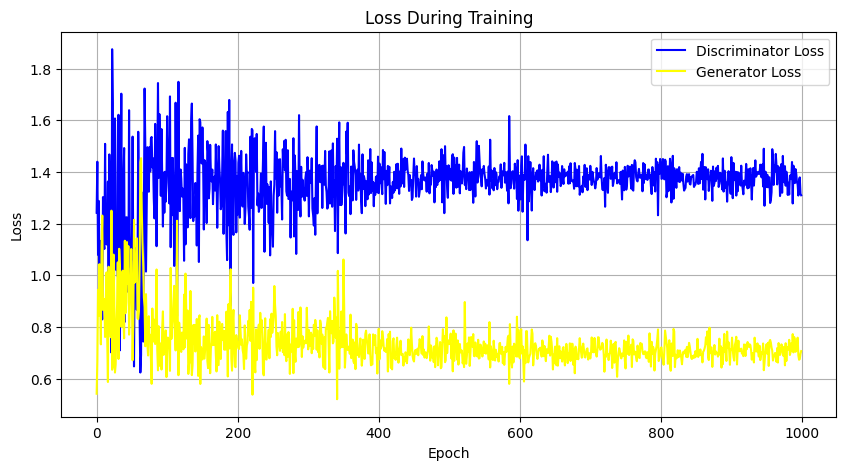

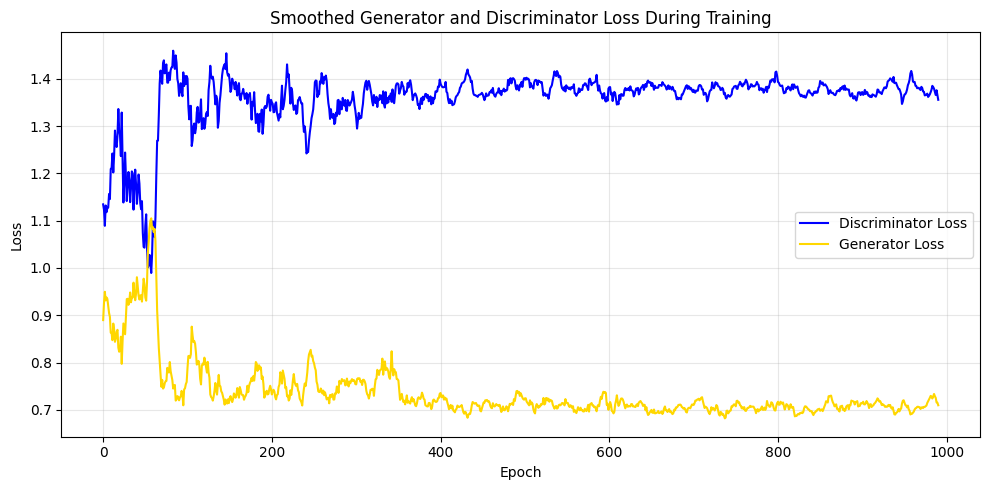

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss', color='blue')
plt.plot(g_losses, label='Generator Loss', color='yellow')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss During Training')
plt.show()

def smooth_curve(values, window=10):
    values = np.array(values)
    if len(values) < window:
        return values
    return np.convolve(values, np.ones(window)/window, mode='valid')
d_losses_smooth = smooth_curve(d_losses, window=10)
g_losses_smooth = smooth_curve(g_losses, window=10)
epochs = np.arange(len(d_losses_smooth))


plt.figure(figsize=(10, 5))
plt.plot(epochs, d_losses_smooth, label='Discriminator Loss', color='blue')
plt.plot(epochs, g_losses_smooth, label='Generator Loss', color='gold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Smoothed Generator and Discriminator Loss During Training')
plt.tight_layout()
plt.show()


In [72]:
generator.eval()
with torch.no_grad():
    z = torch.randn(df.shape[0], latent_dim, device=device)
    gen_data_normalized = generator(z).cpu().numpy() 

gen_data = pd.DataFrame(columns=df.columns)
for i, column in enumerate(df.columns):
    min_val = min_vals[column]
    max_val = max_vals[column]
    gen_data[column] = (gen_data_normalized[:, i] + 1) / 2 * (max_val - min_val) + min_val


### Evaluation

#### a)

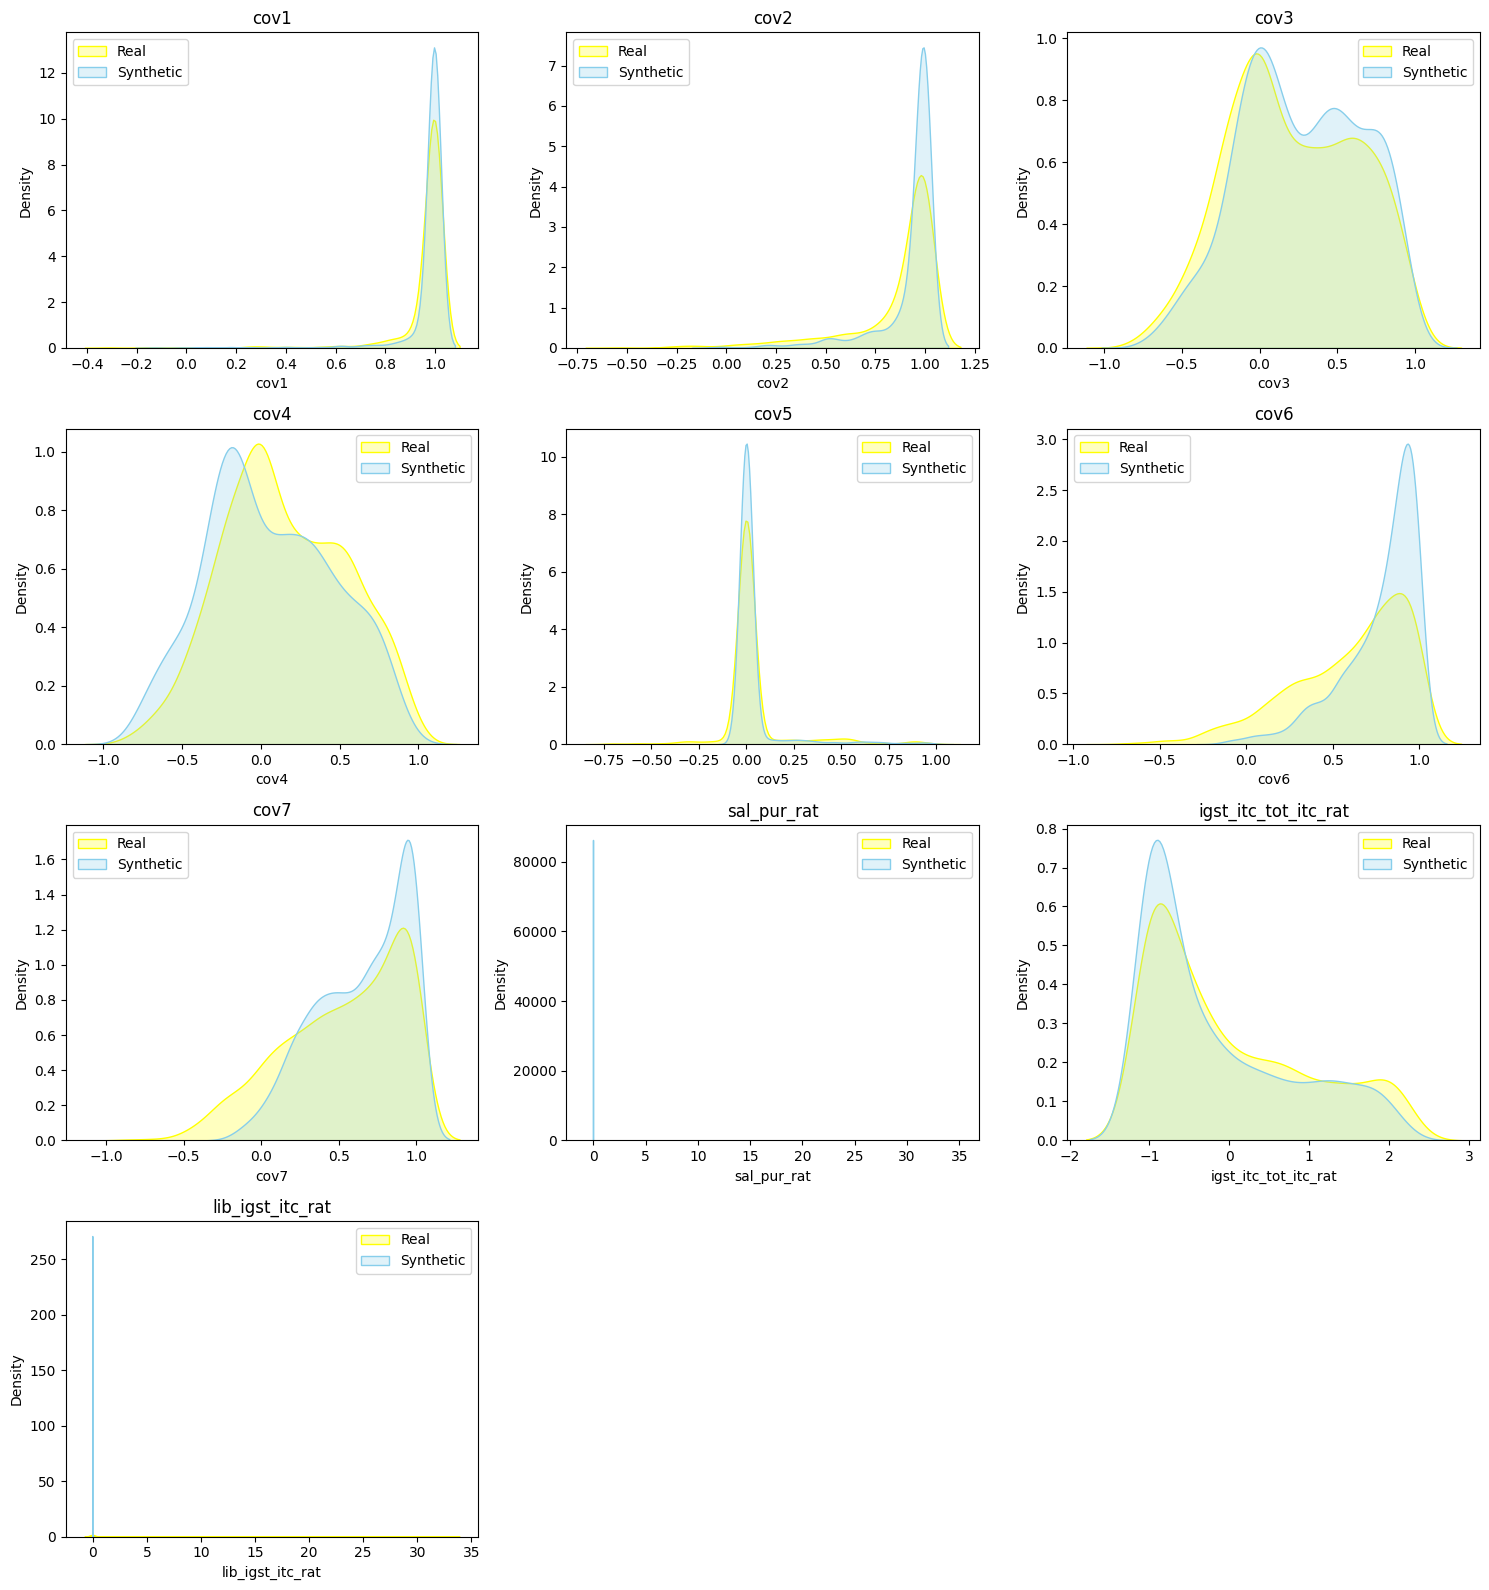

In [73]:
num_features = df.shape[1]
num_rows = (num_features + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))
axes = axes.flatten()
for i, column in enumerate(df.columns):
    if i < len(axes):
        sns.kdeplot(data=df, x=column, ax=axes[i], label='Real', color='yellow', fill=True)
        sns.kdeplot(data=gen_data, x=column, ax=axes[i], label='Synthetic', color='skyblue', fill=True)
        axes[i].set_title(column)
        axes[i].legend()

for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

#### b)

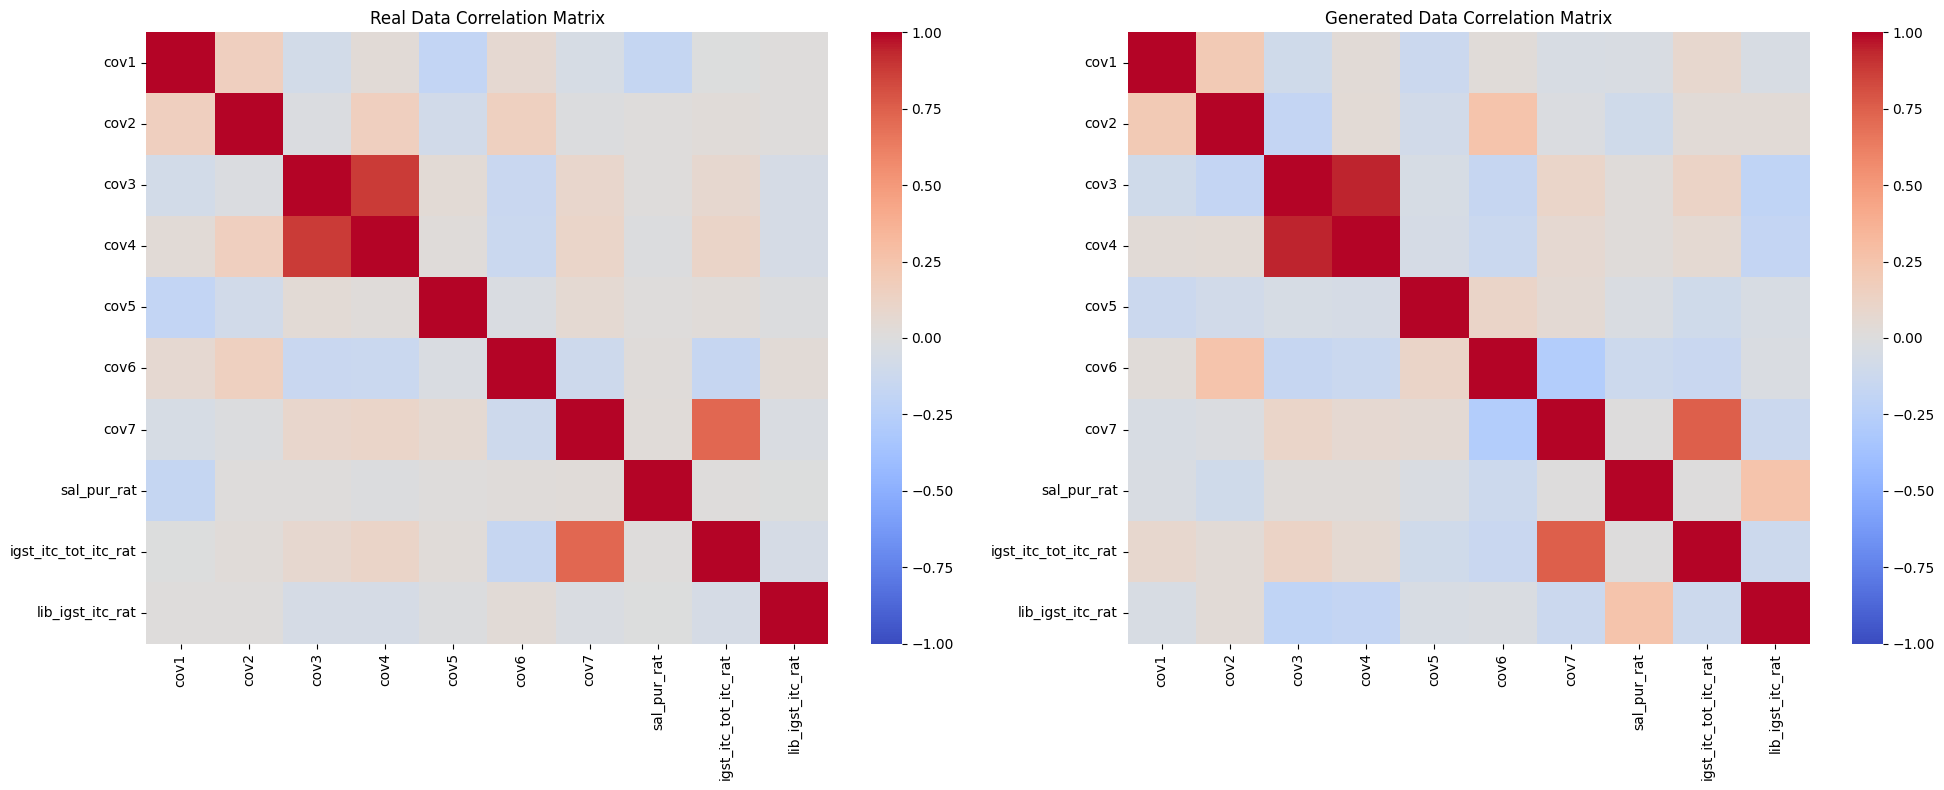

In [74]:
real_corr = df.corr()
gen_corr = gen_data.corr()
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(real_corr, cmap='coolwarm', ax=axes[0], vmin=-1, vmax=1)
sns.heatmap(gen_corr, cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1)
axes[0].set_title('Real Data Correlation Matrix')
axes[1].set_title('Generated Data Correlation Matrix')
plt.tight_layout()
plt.show()

In [77]:
corr_diff = real_corr - gen_corr
corr_diff


,cov1,cov2,cov3,cov4,cov5,cov6,cov7,sal_pur_rat,igst_itc_tot_itc_rat,lib_igst_itc_rat
cov1,0.000000,-0.050072,0.013649,0.000309,-0.049751,0.041299,-0.011246,-0.132329,-0.090561,0.054806
cov2,-0.050072,0.000000,0.153664,0.120931,0.004677,-0.100482,0.007544,0.114060,-0.006796,-0.021638
cov3,0.013649,0.153664,0.000000,-0.069023,0.093099,0.017135,-0.013076,-0.008376,-0.047211,0.139269
cov4,0.000309,0.120931,-0.069023,0.000000,0.075782,0.001738,0.036301,-0.028354,0.059288,0.116286
cov5,-0.049751,0.004677,0.093099,0.075782,0.000000,-0.138187,0.007500,0.041067,0.128289,0.035405
cov6,0.041299,-0.100482,0.017135,0.001738,-0.138187,0.000000,0.162785,0.138724,-0.014874,0.056823
cov7,-0.011246,0.007544,-0.013076,0.036301,0.007500,0.162785,0.000000,0.020362,-0.029666,0.098591
sal_pur_rat,-0.132329,0.114060,-0.008376,-0.028354,0.041067,0.138724,0.020362,0.000000,0.001807,-0.258331
igst_itc_tot_itc_rat,-0.090561,-0.006796,-0.047211,0.059288,0.128289,-0.014874,-0.029666,0.001807,0.000000,0.060214
lib_igst_itc_rat,0.054806,-0.021638,0.139269,0.116286,0.035405,0.056823,0.098591,-0.258331,0.060214,0.000000


In [ ]:
avg_vals = corr_diff.abs().mean()
avg_vals

cov1                    0.044402
cov2                    0.057986
cov3                    0.055450
cov4                    0.050801
cov5                    0.057376
cov6                    0.067205
cov7                    0.038707
sal_pur_rat             0.074341
igst_itc_tot_itc_rat    0.043871
lib_igst_itc_rat        0.084136
dtype: float64